In [1]:
# %%bash
# pip install chroma-haystack qdrant-haystack

In [2]:
from haystack import Document
from haystack import Pipeline, PredefinedPipeline
# from haystack.utils import Secret

from haystack.components.converters.tika import TikaDocumentConverter
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.embedders import HuggingFaceAPIDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack.document_stores.in_memory import InMemoryDocumentStore

/Users/apple/Documents/haystack-book/.venv/lib/python3.9/site-packages/ddtrace/internal/module.py:220: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  self.loader.exec_module(module)


## Predefined Pipeline

In [3]:
# Incase the template produces error, ensure to install `chroma-haystack` dependency
indexing_pipeline_predefined_template = Pipeline.from_template(
    PredefinedPipeline.INDEXING
)

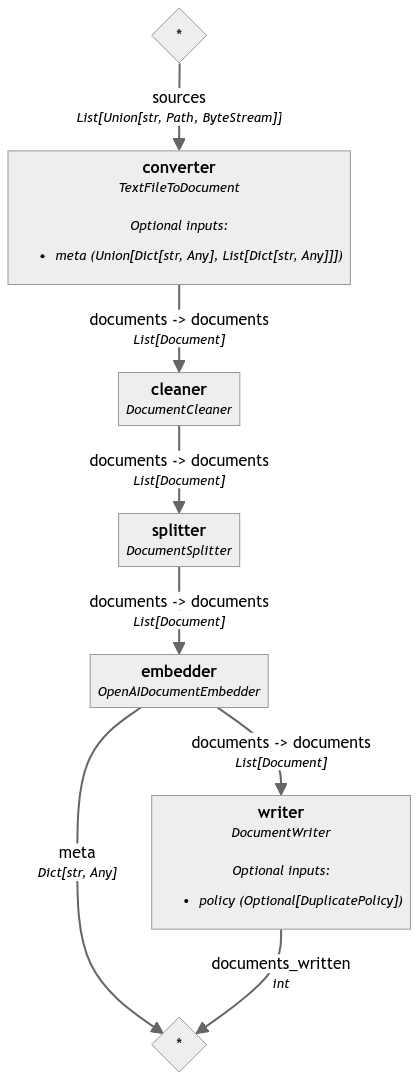

In [4]:
indexing_pipeline_predefined_template.show()

In [5]:
indexing_pipeline_predefined_template.dumps()

"components:\n  cleaner:\n    init_parameters:\n      remove_empty_lines: true\n      remove_extra_whitespaces: true\n      remove_regex: null\n      remove_repeated_substrings: false\n      remove_substrings: null\n    type: haystack.components.preprocessors.document_cleaner.DocumentCleaner\n  converter:\n    init_parameters:\n      encoding: utf-8\n    type: haystack.components.converters.txt.TextFileToDocument\n  embedder:\n    init_parameters:\n      api_base_url: null\n      api_key:\n        env_vars:\n        - OPENAI_API_KEY\n        strict: true\n        type: env_var\n      batch_size: 32\n      dimensions: null\n      embedding_separator: \\n\n      meta_fields_to_embed: []\n      model: text-embedding-ada-002\n      organization: null\n      prefix: ''\n      progress_bar: true\n      suffix: ''\n    type: haystack.components.embedders.openai_document_embedder.OpenAIDocumentEmbedder\n  splitter:\n    init_parameters:\n      split_by: word\n      split_length: 200\n      spl

## Custom Pipeline


In [6]:
# Uncomment if the Tika Convertor throws `ModuleNotFoundError` while instantiating
# %%bash
# pip install tika

In [7]:
# [PDF, JSON, ZIP, TXT, RTF, and all other Apache tika supported document types can be found here: https://tika.apache.org/3.0.0-BETA/formats.html] -> Document Converter
# https://docs.haystack.deepset.ai/reference/converters-api#tikadocumentconverter
# https://tika.apache.org

custom_converter = TikaDocumentConverter()
custom_converter.run(
    sources=["sample.docx", "my_document.rtf", "archive.zip"],  # replace with the actual file locations/path
)

2024-07-03T17:03:22.738644Z [warning  ] Could not read sample.docx. Skipping it. Error: [Errno 2] No such file or directory: 'sample.docx' error=FileNotFoundError(2, 'No such file or directory') lineno=80 module=haystack.components.converters.tika source=sample.docx
2024-07-03T17:03:22.739477Z [warning  ] Could not read my_document.rtf. Skipping it. Error: [Errno 2] No such file or directory: 'my_document.rtf' error=FileNotFoundError(2, 'No such file or directory') lineno=80 module=haystack.components.converters.tika source=my_document.rtf
2024-07-03T17:03:22.740041Z [warning  ] Could not read archive.zip. Skipping it. Error: [Errno 2] No such file or directory: 'archive.zip' error=FileNotFoundError(2, 'No such file or directory') lineno=80 module=haystack.components.converters.tika source=archive.zip


{'documents': []}

In [8]:
# https://docs.haystack.deepset.ai/docs/documentcleaner
# An haystack feature to clean the documents. If this looks very straight forward then you can proceed to using a custom component
custom_cleaner = DocumentCleaner(remove_empty_lines=True)

In [9]:
# https://docs.haystack.deepset.ai/docs/documentsplitter
custom_splitter = DocumentSplitter(split_by="sentence")

In [10]:
# https://docs.haystack.deepset.ai/docs/huggingfaceapitextembedder
# Feel free to replace with any suported embedding model of your choice
custom_embedder = HuggingFaceAPIDocumentEmbedder(
    api_type="serverless_inference_api",
    api_params={"model": "BAAI/bge-small-en-v1.5"},
)

In [11]:
# https://docs.haystack.deepset.ai/docs/documentwriter
custom_document_store = InMemoryDocumentStore()
custom_document_store.write_documents(documents=[Document()])  # type: ignore

1

In [12]:
custom_document_writer = DocumentWriter(
    document_store=custom_document_store, policy=DuplicatePolicy.NONE
)

In [13]:
indexing_pipeline_custom_template = Pipeline()

In [14]:
indexing_pipeline_custom_template.add_component("convertor", custom_converter)
indexing_pipeline_custom_template.add_component("cleaner", custom_cleaner)
indexing_pipeline_custom_template.add_component("splitter", custom_splitter)
indexing_pipeline_custom_template.add_component("embedder", custom_embedder)
indexing_pipeline_custom_template.add_component("writer", custom_document_writer)

In [15]:
indexing_pipeline_custom_template.connect("convertor", "cleaner")
indexing_pipeline_custom_template.connect("cleaner", "splitter")
indexing_pipeline_custom_template.connect("splitter", "embedder")
indexing_pipeline_custom_template.connect("embedder", "writer")

🚅 Components
  - convertor: TikaDocumentConverter
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - embedder: HuggingFaceAPIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - convertor.documents -> cleaner.documents (List[Document])
  - cleaner.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

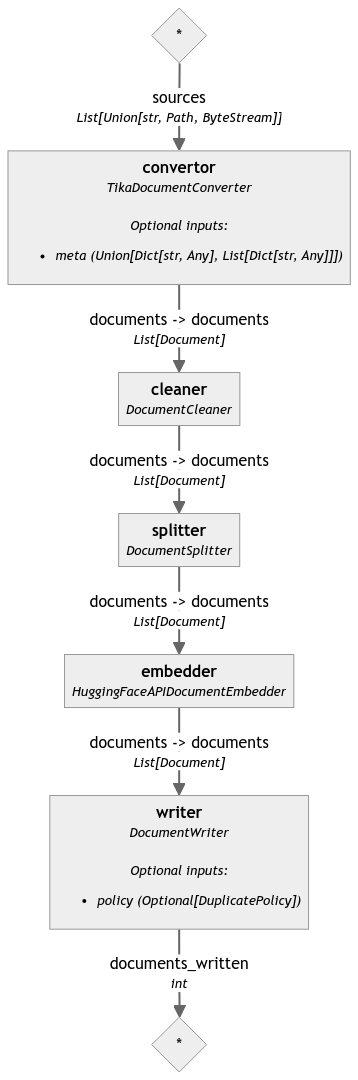

In [16]:
indexing_pipeline_custom_template.show()

In [17]:
indexing_pipeline_custom_template.dumps()

"components:\n  cleaner:\n    init_parameters:\n      remove_empty_lines: true\n      remove_extra_whitespaces: true\n      remove_regex: null\n      remove_repeated_substrings: false\n      remove_substrings: null\n    type: haystack.components.preprocessors.document_cleaner.DocumentCleaner\n  convertor:\n    init_parameters:\n      tika_url: http://localhost:9998/tika\n    type: haystack.components.converters.tika.TikaDocumentConverter\n  embedder:\n    init_parameters:\n      api_params:\n        model: BAAI/bge-small-en-v1.5\n      api_type: serverless_inference_api\n      batch_size: 32\n      embedding_separator: '\n\n        '\n      meta_fields_to_embed: []\n      normalize: false\n      prefix: ''\n      progress_bar: true\n      suffix: ''\n      token:\n        env_vars:\n        - HF_API_TOKEN\n        strict: false\n        type: env_var\n      truncate: true\n    type: haystack.components.embedders.hugging_face_api_document_embedder.HuggingFaceAPIDocumentEmbedder\n  split